# Analysis on 2D Heisenberg model

In [1]:
import multiprocessing

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import os

from heisenberg_2d import initialize, metropolis, energy, magnetization

In [2]:
# Settings
snaps = []
n_temp = 100

N = 10
H = 1
steps = 100
temp = np.linspace(1.5,3.5,n_temp)

## Routine

In [3]:
# %%timeit -n1 -r1

## small sanity check on input parameters
if N<2 or steps<1 or temp[0]<0:
    print("Invalid command line parameters")

## parameters to calculate running average (notice that these are averages per spin)
n1 = 1.0/(steps*N*N)
n2 = 1.0/(steps*steps*N*N)
   
def start(T: float):
    """ Run the routine for temperature T and return E, M, C, X"""
# for ii, T in enumerate(temp):
    E1=0
    M1=0
    E2=0
    M2=0
    grid = initialize(N) ## get the initial configuration
    beta = 1.0/T ## k_B = 1  


    ## first we equilibrate the system 
    ## (assumption is that snapshots are wanted here)
    for t in range(steps):
        if t in snaps:
            plot_system(grid, t, T, H)

        metropolis(grid, beta, H)

    ## then we start to actually collect data, if we aren't just plotting snapshots
    if len(snaps)==0:
        for t in range(steps):
            metropolis(grid, beta, H)
            tE = energy(grid, H)
            tM = magnetization(grid)

            E1 += tE
            E2 += tE*tE
            M1 += tM
            M2 += tM*tM

        E = n1*E1
        M = n1*M1
        C = beta*beta*(n1*E2 - n2*E1*E1)
        X = beta*(n1*M2 - n2*M1*M1)
        
    return E, M, C, X

In [4]:
# Run the routine in parallel (NB: might not work on windows)
with multiprocessing.Pool() as pool:
    results = pool.map(start, temp)
    E, M, C, X = np.array(results).T

In [5]:
# gather results in a table just in case
df = pd.DataFrame(results, columns=['E', 'M', 'C', 'X'])
display(df)

,E,M,C,X
0,-1.247188,0.99875,0.005273,0.001562
1,-1.247188,0.99875,0.005134,0.001542
2,-1.247188,0.99875,0.005000,0.001522
3,-1.247188,0.99875,0.004872,0.001502
4,-1.247188,0.99875,0.004748,0.001483
...,...,...,...,...
95,-0.900000,0.80000,0.073348,0.125761
96,-0.938438,0.82625,0.077857,0.154415
97,-0.903438,0.80875,0.080018,0.117021
98,-0.889062,0.79625,0.087054,0.188544


## Plotting

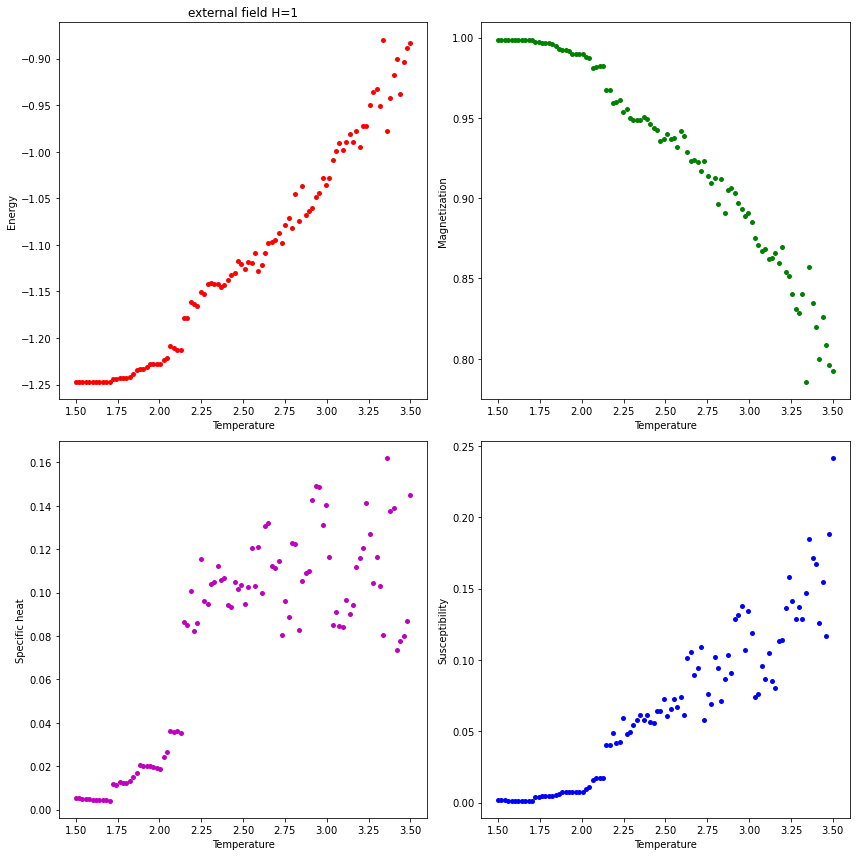

In [6]:
## then we plot a figure with energy, magnetization, specific heat and susceptibility
if len(snaps)==0:
    plt.figure(figsize=(12,12))

    plt.subplot(2,2,1)
    plt.title('external field H={}'.format(H))
    plt.plot(temp, E, 'ro', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Energy')

    plt.subplot(2,2,2)
    plt.plot(temp, M, 'go', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Magnetization')

    plt.subplot(2,2,3)
    plt.plot(temp, C, 'mo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Specific heat')

    plt.subplot(2,2,4)
    plt.plot(temp, X, 'bo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Susceptibility')


    plt.tight_layout()
    ## uncomment if you want to save the data
    #np.savetxt("ising_2d_{}_{}_{}.dat".format(N,steps,H), np.array([temp, E, M , C,X]).transpose())

plt.show()
